In [1]:
import sys

sys.path.insert(0, '..')

from typing import Any, Dict, List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

from data_utils import DATAFILE_LIST, NUM_CLASSES_DICT, prepare_data, CIFAR100_CLASSES, FIGURE_DIR
from models import BetaBernoulli, ClasswiseEce

%matplotlib inline  
LINEWIDTH = 13.97

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

In [13]:
def vstripe(ax: mpl.axes.Axes,
            x: np.ndarray,
            labels: List[str] = None,
            limit: int = None,
            color: str = 'red') -> None:
    
    num_columns = x.shape[0]
    labels = labels if labels is not None else list(range(num_columns))

    # Apply limit
    sentinel = np.empty((1, 3))
    sentinel[:] = np.nan
    if limit is not None:
        x = np.concatenate((x[:limit], sentinel, x[-limit:]), axis=0)
        labels = labels[:limit] + ['...'] + labels[-limit:]
        num_columns = x.shape[0]
    # Plot
    for i, row in enumerate(x):
        low, mid, high = row.tolist()
        ax.plot((i, i), (low, high), color = color)
        ax.plot((i - .2, i + .2), (mid, mid), color = color)

    # Add labels
    ax.set_xlim(-1, num_columns)
    ax.set_xticks(np.arange(num_columns))
    ax.set_xticklabels(labels, rotation=40, fontsize=12)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


def plot_figure_1(accuracy: np.ndarray,
                  ece: np.ndarray,
                  labels: List[str] = None,
                  limit: int = None,
                  reverse: bool = False):
    
    assert accuracy.shape == ece.shape
    # Sort the datapoints and labels
    sort_indices = np.argsort(accuracy[:, 1])
    if reverse:
        sort_indices = sort_indices[::-1]
    accuracy = accuracy[sort_indices]
    ece = ece[sort_indices]
    if labels is not None:
        labels = [labels[i] for i in sort_indices]

    # Plot
    fig, axes = plt.subplots(nrows=2, dpi=300, sharex=True, figsize=(LINEWIDTH*0.5, 5), 
                        gridspec_kw = {'wspace':0.25, 'hspace':0.2})
    vstripe(axes[0], accuracy, labels=labels, limit=limit, color='blue')
    axes[0].set_ylim(top=1.0)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].tick_params(bottom=False)

    # axes[1].vlines(0, -1, ece.shape[0] + 1, colors='#777777', linewidth=1, linestyle='dashed')
    vstripe(axes[1], ece, labels=labels, limit=limit, color='red')
    axes[1].set_ylim(bottom=0)
    axes[1].set_ylabel('ECE', fontsize=12)
    axes[1].set_xlabel("CIFAR-100 Labels", fontsize=14)

    return fig, axes

/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


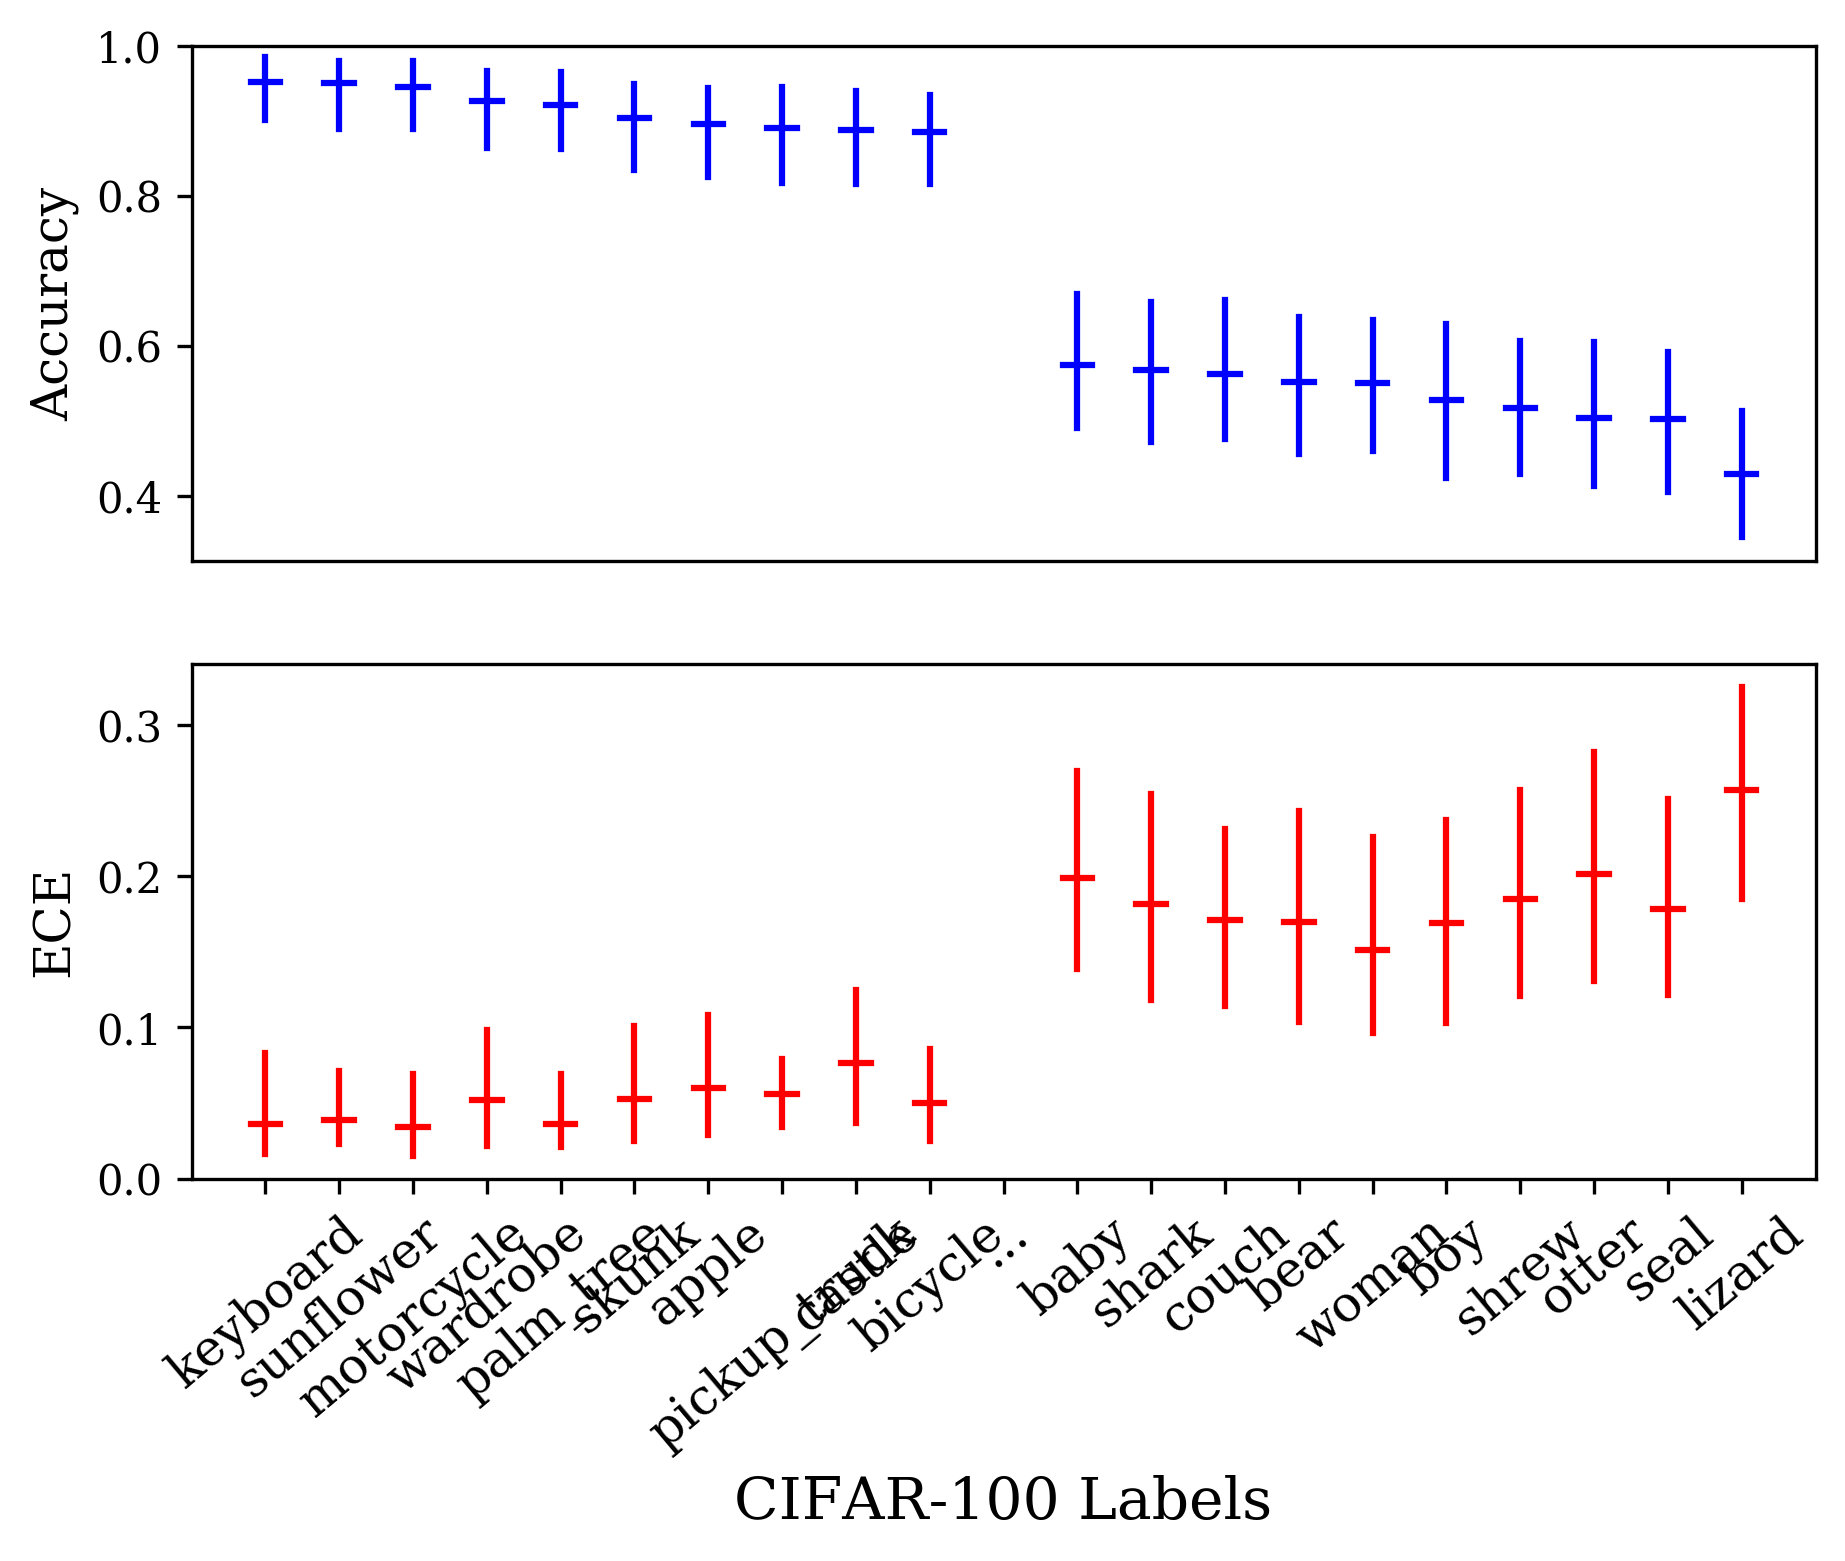

In [17]:
dataset = 'cifar100'
num_samples = 1000
limit=10

datafile = DATAFILE_LIST[dataset]
num_classes = NUM_CLASSES_DICT[dataset]
categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)
# accuracy models
accuracy_model = BetaBernoulli(k=num_classes, prior=None)
accuracy_model.update_batch(categories, observations)
# ece models for each class
ece_model = ClasswiseEce(num_classes, num_bins=10, pseudocount=2)
ece_model.update_batch(categories, observations, confidences)

# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples)  # (num_categories, num_samples)
ece_samples = ece_model.sample(num_samples)  # (num_categories, num_samples)

accuracy = np.array([np.quantile(accuracy_samples, 0.025, axis=1),
                     np.quantile(accuracy_samples, 0.5, axis=1),
                     np.quantile(accuracy_samples, 0.975, axis=1)]).T
ece = np.array([np.quantile(ece_samples, 0.025, axis=1),
                np.quantile(ece_samples, 0.5, axis=1),
                np.quantile(ece_samples, 0.975, axis=1)]).T
fig, axes = plot_figure_1(accuracy, ece, labels=CIFAR100_CLASSES, limit=limit, reverse=True)

fig.tight_layout()

In [4]:
fig.savefig(FIGURE_DIR + 'figure1.pdf', bbox_inches="tight", pad_inches=0.05)

In [30]:
######################################CONSTANTS######################################
DEFAULT_PLOT_KWARGS = {
    'color': 'blue',
    'linewidth': 1
}
DEFAULT_RC = {
    'font.size': 8,
    'font.family': 'serif',
    'font.serif': ['Times'],
    # 'text.usetex': True,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'figure.titlesize': 8
}
COLUMN_WIDTH = 3.25  # Inches

######################################CONSTANTS######################################
import sys

sys.path.insert(0, '..')

from typing import Any, Dict, List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

from data_utils import DATAFILE_LIST, NUM_CLASSES_DICT, prepare_data, CIFAR100_CLASSES, FIGURE_DIR
from models import BetaBernoulli, ClasswiseEce


def hstripe(ax: mpl.axes.Axes,
            x: np.ndarray,
            labels: List[str] = None,
            limit: int = None,
            plot_kwargs: Dict[str, Any] = {}) -> None:
    """
    Plots a horizontal stripe plot in the given axis.

    Parameters
    ===
    ax : matplotlib.axes.Axes
        The axis to add the plot to.
    x : numpy.ndarray
        An array of shape (n_classes, 3) where:
            x[:, 0] is the lower bounds
            x[:, 1] is the midpoints
            x[:, 2] is the upper bounds
    labels : list
        A list containing `n_classes` labels. Default: class indices are used.
    limit : int
        Limits the number of data points displayed; the middle data points are skipped.
        Default: all data points plotted.
    plot_kwargs : dict
        Keyword arguments passed to the plot.
    """
    num_rows = x.shape[0]
    labels = labels if labels is not None else list(range(num_rows))

    # Combine default and custom kwargs
    # TODO: @rloganiv - find a clearner way to merge dictionaries
    _plot_kwargs = DEFAULT_PLOT_KWARGS.copy()
    _plot_kwargs.update(plot_kwargs)

    # Apply limit
    sentinel = np.empty((1, 3))
    sentinel[:] = np.nan
    if limit is not None:
        x = np.concatenate((x[:limit], sentinel, x[-limit:]), axis=0)
        labels = labels[:limit] + ['...'] + labels[-limit:]
        num_rows = x.shape[0]

    # Plot
    for i, row in enumerate(x):
        low, mid, high = row.tolist()
        ax.plot((low, high), (i, i), **_plot_kwargs)
        ax.plot((mid, mid), (i - .2, i + .2), **_plot_kwargs)

    # Add labels
    ax.set_ylim(-1, num_rows)
    ax.set_yticks(np.arange(num_rows))
    ax.set_yticklabels(labels)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


def plot_figure_1(accuracy: np.ndarray,
                  ece: np.ndarray,
                  labels: List[str] = None,
                  limit: int = None,
                  reverse: bool = False):
    """
    Replicates Figure 1 in [CITE PAPER].

    Parameters
    ===
    accuracy : np.ndarray
        An array of shape (n_classes, 3) where:
            x[:, 0] is the lower bounds
            x[:, 1] is the midpoints
            x[:, 2] is the upper bounds
        Contains the accuracy data plotted in the left plot.
    ece : np.ndarray
        Simlar to left, except data is plotted in the right plot.
    labels : list
        A list containing `n_classes` labels. Default: class indices are used.
    limit : int
        Limits the number of data points displayed; the middle data points are skipped.
        Default: all data points plotted.
    reverse : bool
        Whether to reverse the vertical ordering. Default: highest value to be at top.

    Returns
    ===
    fig, axes : The generated matplotlib Figure and Axes.
    """
    assert accuracy.shape == ece.shape

    # Sort the datapoints and labels
    sort_indices = np.argsort(accuracy[:, 1])
    if reverse:
        sort_indices = sort_indices[::-1]
    accuracy = accuracy[sort_indices]
    ece = ece[sort_indices]
    if labels is not None:
        labels = [labels[i] for i in sort_indices]

    # Plot
    with mpl.rc_context(rc=DEFAULT_RC):
        fig, axes = plt.subplots(ncols=2, figsize=(3, 3), dpi=300, sharey=True)
        plot_kwargs = {'color': 'tab:blue'}
        hstripe(axes[0], accuracy, labels=labels, limit=limit, plot_kwargs=plot_kwargs)
        axes[0].set_xlim(right=1.0)
        axes[0].set_title('Accuracy')

        # axes[1].vlines(0, -1, ece.shape[0] + 1, colors='#777777', linewidth=1, linestyle='dashed')
        plot_kwargs = {'color': 'tab:red'}
        hstripe(axes[1], ece, labels=labels, limit=limit, plot_kwargs=plot_kwargs)
        axes[1].set_xlim(left=0)
        axes[1].tick_params(left=False)
        axes[1].set_title('ECE')

        #axes[0].text(-0.5, 10, "CIFAR-100 Labels", verticalalignment='center', rotation=90)

    return fig, axes



dataset = 'cifar100'
num_samples = 1000

datafile = DATAFILE_LIST[dataset]
num_classes = NUM_CLASSES_DICT[dataset]

categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)

# accuracy models
accuracy_model = BetaBernoulli(k=num_classes, prior=None)
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_model = ClasswiseEce(num_classes, num_bins=10, pseudocount=2)
ece_model.update_batch(categories, observations, confidences)

# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples)  # (num_categories, num_samples)
ece_samples = ece_model.sample(num_samples)  # (num_categories, num_samples)

accuracy = np.array([np.quantile(accuracy_samples, 0.025, axis=1),
                     np.quantile(accuracy_samples, 0.5, axis=1),
                     np.quantile(accuracy_samples, 0.975, axis=1)]).T
ece = np.array([np.quantile(ece_samples, 0.025, axis=1),
                np.quantile(ece_samples, 0.5, axis=1),
                np.quantile(ece_samples, 0.975, axis=1)]).T

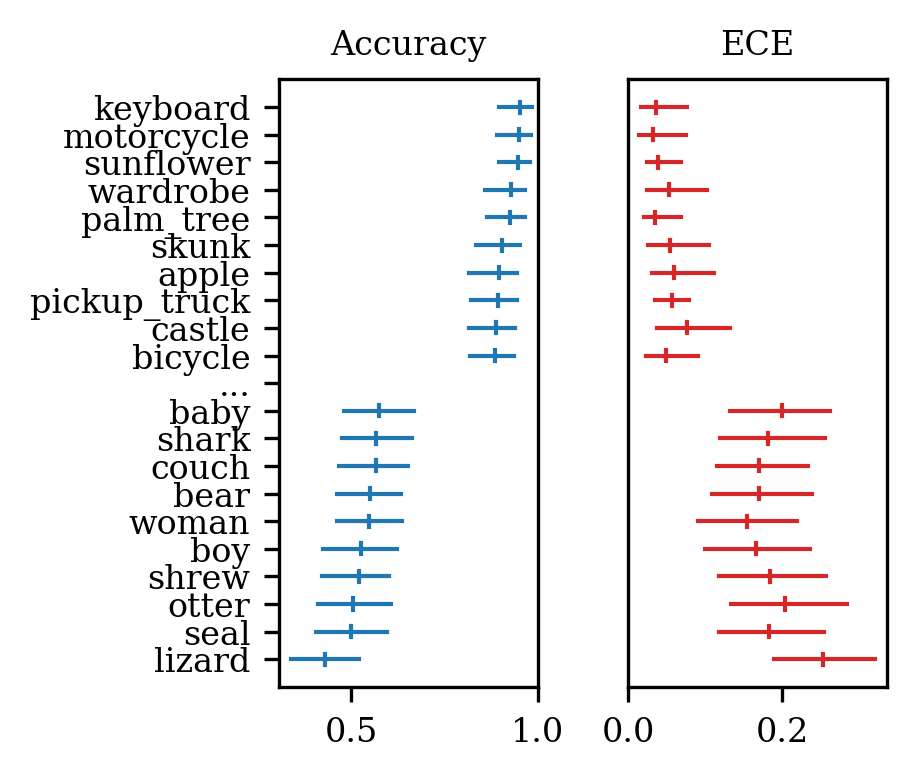

In [34]:
fig, axes = plot_figure_1(accuracy, ece, labels=CIFAR100_CLASSES, limit=10, reverse=False)

fig.tight_layout()
fig.subplots_adjust(bottom=-0.2, wspace=0.35)
fig.set_size_inches(COLUMN_WIDTH, 1.85)
fig.savefig(FIGURE_DIR + 'figure1.pdf', bbox_inches="tight", pad_inches=0.0)